<a href="https://colab.research.google.com/github/gaborigenes/diabetes_prognosis/blob/main/diabetes_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Procedimiento
- Cargar el Dataset
- Preparar la data, para esto ser hará:
  - visualizacion y exploración de la data
  - Lidiar con datos faltantes
- Desarrollo del modelo
  - Uso de modelo de pronostico lineal
  - Pesos ponderados para Lidiar con imbalance de la data
- Evaluación del modelo

In [1]:
import shap
import sklearn
import itertools
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam, Adadelta, RMSprop
import tensorflow.keras.backend as K
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    precision_score,
    recall_score,
    )

In [2]:
df = pd.read_csv('diabetes_normalizada.csv', delimiter=';')
X = df.drop(['CLASS_Y'], axis=1)
y = df['CLASS_Y']

In [30]:
X.shape

(1009, 9)

In [4]:
y.unique()
#y_encoded = tf.keras.utils.to_categorical(y)

array([0, 1])

In [5]:
#Generamos los splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

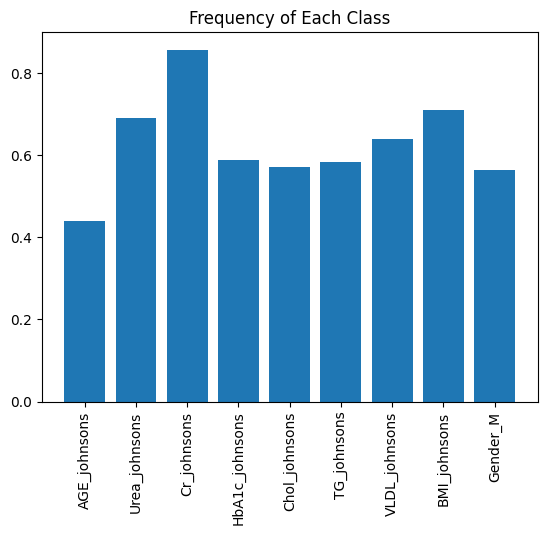

In [6]:
plt.xticks(rotation=90)
plt.bar(x=X_train.columns, height= X_train.mean())
plt.title("Frequency of Each Class")
plt.show()

In [8]:
def class_freqs(labels):

    # numero dep pacientes (filas)
    N = labels.shape[0]

    frecuencia_positiva = np.sum(labels, axis=0) / labels.shape[0]
    frecuencia_negativa = 1-frecuencia_positiva

    return frecuencia_positiva, frecuencia_negativa

In [75]:
frec_pos, frec_neg = class_freqs(X_train)

print(f"porcentaje de frecuencia positivas:\n {frec_pos*100}")
print("========================")
print(f"porcentaje de frecuencia positiva:\n {frec_neg*100}")

porcentaje de frecuencia positivas:
 AGE_johnsons      44.106408
Urea_johnsons     69.027129
Cr_johnsons       85.802614
HbA1c_johnsons    58.823088
Chol_johnsons     57.089589
TG_johnsons       58.277506
VLDL_johnsons     64.091462
BMI_johnsons      71.153148
Gender_M          56.349206
dtype: float64
porcentaje de frecuencia positiva:
 AGE_johnsons      55.893592
Urea_johnsons     30.972871
Cr_johnsons       14.197386
HbA1c_johnsons    41.176912
Chol_johnsons     42.910411
TG_johnsons       41.722494
VLDL_johnsons     35.908538
BMI_johnsons      28.846852
Gender_M          43.650794
dtype: float64


En las clases positivas se puede verificar que

1. AGE tiene buen balance entre clases
2. Urea tiene el 69% (desbalance)
3. Cr tiene el 85% (gran desbalance)
4. HbA1c, Chol, TG tiene 58%,57%, 58% respectivamente no esta desbalanceado
5. VLDL tiene 64% esta ligeramente desbalanceado
6. BDMI tiene el 71% tiene desbalance


En el siguiente histograma se puede evidenciar la distinciones entre clases



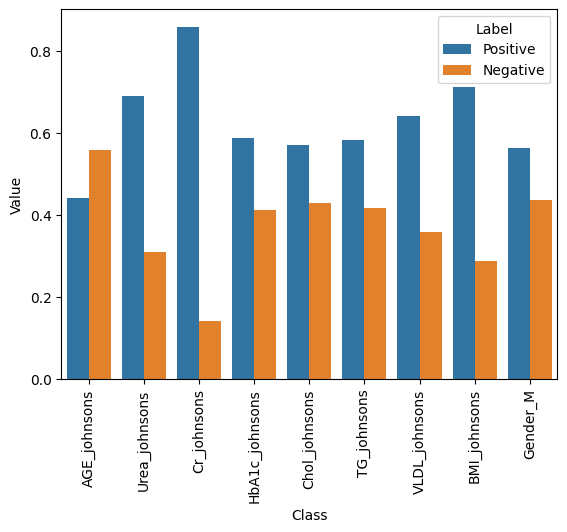

In [10]:
data = pd.DataFrame({"Class": X_train.columns, "Label": "Positive", "Value": frec_pos})
data2 = pd.DataFrame([{"Class": X_train.columns[l], "Label": "Negative", "Value": v}
                         for l, v in enumerate(frec_neg)])


data = pd.concat([data, data2], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

Ademas, entre las clases positivas y negativas hay gran desbalances

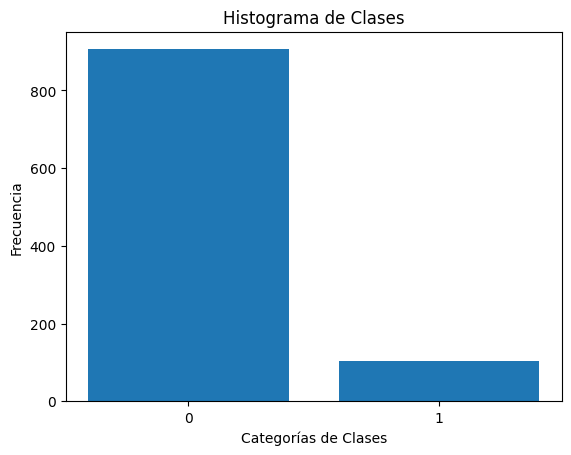

In [7]:
#Entre las clases también hay gran desbalance
classes = df.CLASS_Y.unique()
class_counts = df.CLASS_Y.value_counts()
plt.bar(classes,class_counts, )
plt.xticks(classes)  # Ajusta el ángulo de rotación si es necesario
plt.xlabel('Categorías de Clases')
plt.ylabel('Frecuencia')
plt.title('Histograma de Clases')
plt.show()

Si usamos la entropía cruzada clásica el modelo va a predecir una probabilidad muy baja de enfermedad para todos y le costará identificar cual ejemplo tiene una enfermedad, es decir, favorecerá a una clase.



Una manera de arreglar esto es ponderando los pesos, multiplicando cada ejemplo de cada clase por un valor de peso de tal manera que la contribución de cada clase sea la misma

$\omega_pf_p = \omega_nf_n $

se puede lograr haciendo
$\omega_p = f_n$
$\omega_n = f_p$

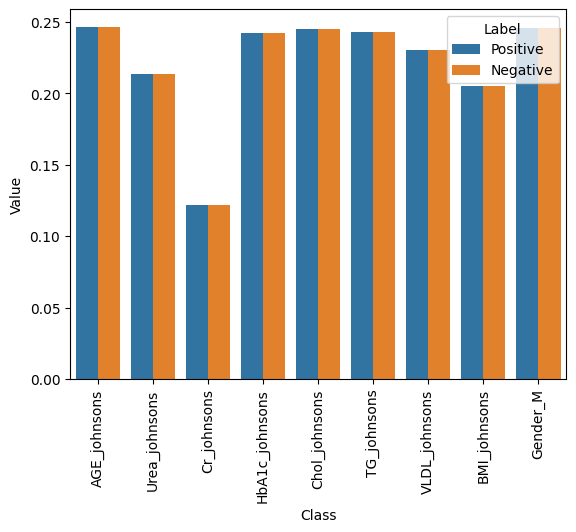

In [11]:
pesos_pos = frec_neg
pesos_neg = frec_pos
contribucion_positiva = frec_pos * pesos_pos
contribucion_negativa = frec_neg*pesos_neg

data = pd.DataFrame({"Class": X_train.columns, "Label": "Positive", "Value":contribucion_positiva})
data2 = pd.DataFrame([{"Class": X_train.columns[l], "Label": "Negative", "Value": v}
                         for l, v in enumerate(contribucion_negativa)])


data = pd.concat([data, data2], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)


 De esta manera tanto la clase positiva como la clase negativa tendran la misma contribución a la función de perdida, ahora la función de perdida en vez de ser la entropía cruzada clásica, será:

 $$L_{cross-entropy}^{w}(x) = - (w_{p}ylog(f(x)) + w_{n}(1-y) log( 1 - f(x) ) )$$


In [12]:
def get_weighted_loss(pos_weight, neg_weight, epsilon=1e-7):
    """
    Retorna la función de pesos ponderados
    Args:
      pesos_positivos (np.array): arreglo de pesos positivos para cada clase, size(num_classes)
      pesos_negativos (np.array): arreglo de pesos negativos para cada clase, size(num_classes)
    """
    def weighted_loss(y_true, y_pred):
        """
        Args:
            y_true (Tensor): Tensor con etiquetas reales, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor con etiquetas predichas, size is (num_examples, num_classes)
        Returns:
            loss (Tensor): escalar de perdida general sumado a lo largo de todas las clases overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        print('shapes: ',y_true.shape,y_pred.shape)
        pos_weights = tf.constant(pos_weight, dtype=tf.float32)  # Adjust based on class imbalance
        neg_weights = tf.constant(pos_weight, dtype=tf.float32)


        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
        y_pred = K.clip(y_pred, epsilon, 1 - epsilon)
        loss = -(K.mean(pos_weights * y_true * K.log(y_pred) + neg_weights * (1 - y_true) * K.log(1 - y_pred)))

        #for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class
         #   loss += -(K.mean( pos_weights[i] * y_true[:,i] * K.log(y_pred[:,i] + epsilon) + \
          #                      neg_weights[i] * (1 - y_true[:,i]) * K.log(1 - y_pred[:,i] + epsilon), axis = 0))

        return loss

        ### END CODE HERE ###
    return weighted_loss

In [139]:
def crear_modelo():
  model = Sequential()
  model.add(Dense(9, input_shape = (9,), activation = 'relu',name= 'oculta_1'))
  model.add(Dense(9, input_shape = (1,), activation = 'relu',name= 'oculta_2'))
  model.add(Dense(1, activation = 'sigmoid',name= 'salida'))
  model.compile(
       optimizer ='adam',
       loss = get_weighted_loss(frec_pos,frec_neg),
       metrics = ['accuracy']
                )
  return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ oculta_1 (Dense)                     │ (None, 9)                   │              90 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ oculta_2 (Dense)                     │ (None, 9)                   │              90 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ salida (Dense)                       │ (None, 1)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 190 (760.00 B)

 Trainable params: 190 (760.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
shapes:  (None, 1) (None, 1)
shapes:  (None, 1) (None, 1)
24/24 - 2s - 86ms/step - accuracy: 0.8902 - loss: 0.2599
Epoch 2/200
24/24 - 0s - 6ms/step - accuracy: 0.8902 - loss: 0.2117
Epoch 3/200
24/24 - 0s - 6ms/step - accuracy: 0.8902 - loss: 0.1982
Epoch 4/200
24/24 - 0s - 6ms/step - accuracy: 0.8902 - loss: 0.1963
Epoch 5/200
24/24 - 0s - 6ms/step - accuracy: 0.8902 - loss: 0.1957
Epoch 6/200
24/24 - 0s - 6ms/step - accuracy: 0.8902 - loss: 0.1945
Epoch 7/200
24/24 - 0s - 6ms/step - accuracy: 0.8902 - loss: 0.1935
Epoch 8/200
24/24 - 0s - 7ms/step - accuracy: 0.8902 - loss: 0.1923
Epoch 9/200
24/24 - 0s - 10ms/step - accuracy: 0.8902 - loss: 0.1911
Epoch 10/200
24/24 - 0s - 6ms/step - accuracy: 0.8902 - loss: 0.1897
Epoch 11/200
24/24 - 0s - 6ms/step - accuracy: 0.8902 - loss: 0.1887
Epoch 12/200
24/24 - 0s - 6ms/step - accuracy: 0.8902 - loss: 0.1873
Epoch 13/200
24/24 - 0s - 6ms/step - accuracy: 0.8902 - loss: 0.1857
Epoch 14/200
24/24 - 0s - 6ms/step - accuracy: 0.890

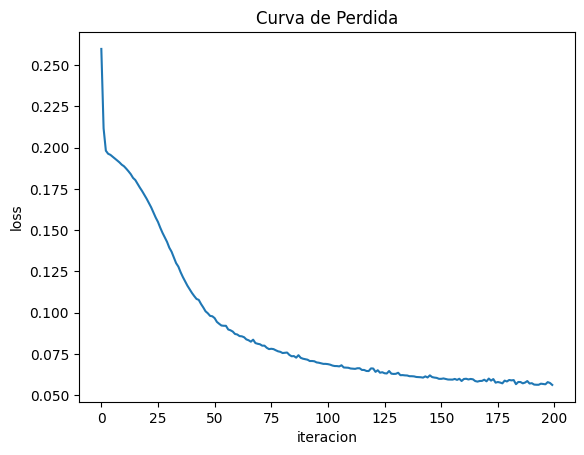

In [140]:
model = crear_modelo()
model.summary()
history = model.fit(          X_train,
                              y_train,
                              #steps_per_epoch=100,
                              #validation_split=0.20,
                              epochs = 200,
                              verbose = 2)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("iteracion")
plt.title("Curva de Perdida")
plt.show()

In [141]:
def prediction(X_test, y_test):
  #this function returns te prediction of the values given a test input

  #params:
  #X_test: test instances vector of shape (len(x_test), 9) type: pandas Dataframe
  #y_test: test class vector of shape (len(x_test), 9) type: pandas Dataframe

  #return: y_pred binary vector, 0 if y_pred<threshold, 1 otherwise.

  from sklearn.metrics import roc_curve
  # Get predicted probabilities
  y_pred_probs = model.predict(X_test)
  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
  # Find the optimal threshold (closest to top-left corner)
  optimal_idx = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal_idx]
  print(f"Optimal Threshold: {optimal_threshold}")
  # Convert probabilities to binary using the optimal threshold
  y_pred = (y_pred_probs > optimal_threshold).astype(int)
  return y_pred

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Optimal Threshold: 0.7486670613288879
exactitud :94.07 %
precision :96.61 %
puntaje f1 :94.78 %


<Axes: >

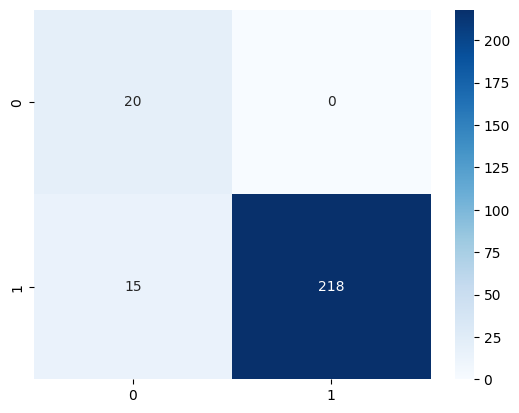

In [142]:
y_pred = prediction(X_test, y_test)



cm = confusion_matrix(y_test, y_pred)
exactitud = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred,average = 'weighted')
f1 = f1_score(y_test,y_pred,average = 'weighted')
print('exactitud :{:.2f} %'.format(exactitud*100))
print('precision :{:.2f} %'.format(precision*100))
print('puntaje f1 :{:.2f} %'.format(f1*100))
sns.heatmap(cm, annot = True, cmap='Blues', fmt='d')

Además de las maneras clásicas de medir un modelo, en el ámbito médico se utiliza un método para evaluarlos llamado c-index

c-index mide la potencia discriminantoria de un puntaje de riesgo. Intuitivamente, un algo c-index indica que la predicción del modelo está en consonancia con la salud de los pacientes. Su ecuación viene dada por

$$C = \frac{concordantes +0.5*empates}{permisibles} $$

donde

1.   Un par permisible es un par de pacientes con diferentes diagnostico
2.   Un par concordante es un par permisible en el cual el paciente con mayor riesgo tiene el peor diagnóstico
3. Un empate es un par permisible donde los pacientes tienen el mismo riesgo



In [47]:
def cindex(y_true, scores):
   '''
    Input:
    y_true (np.array): a 1-D array of true binary outcomes (values of zero or one)
        0: patient does not get the disease
        1: patient does get the disease
    scores (np.array): a 1-D array of corresponding risk scores output by the model

    Output:
    c_index (float): (concordant pairs + 0.5*ties) / number of permissible pairs
    '''

   n = len(y_true)
   assert len(scores) == n

   concordant = 0
   permisible = 0
   ties = 0

   #usamos ciclos for anidados para ir a través de todos los pares unicos de pacientes
   for i in range(n):
     for j in range (i+1,n): #range so that j>i
       # Check if the pair is permissible (the patient outcomes are different)
       if y_true[i] != y_true[j]:
         permisible +=1
          #for permisible pais, check if they are concordant or ties
         if scores[i] == scores[j]:
           ties +=1
           #if tie, doesn't need to check outcome
           continue


         # case 1: patient i doesn't get the disease, patient j does
         if y_true[i] == 0 and y_true[j] == 1:
           #check if i has lower risk than j
           if scores[i] < scores[j]:
             concordant +=1
             # Otherwise if patient i has a higher risk score, it's not a concordant pair.
             # Already checked for ties earlier


          #case 2: patient i gets the disease, patient j does not
         if y_true[i] ==1 and y_true[j] ==0:
           #check if i has higher than j
           if scores[i] > scores[j]:
             concordant +=1
             # Otherwise if patient i has a lower risk score, it's not a concordant pair.
             # We already checked for ties earlier
   c_index = (concordant+0.5*ties)/permisible
   return c_index


In [143]:
scores = pd.DataFrame(y_pred, columns = ['labels'])
scores = scores.values.ravel()
scores.shape
c_index_X_test = cindex(y_test.values, scores)
print(f"c-index on test set is {c_index_X_test:.4f}")

c-index on test set is 0.9678


Veamos cuales variables hicieron gran diferencia

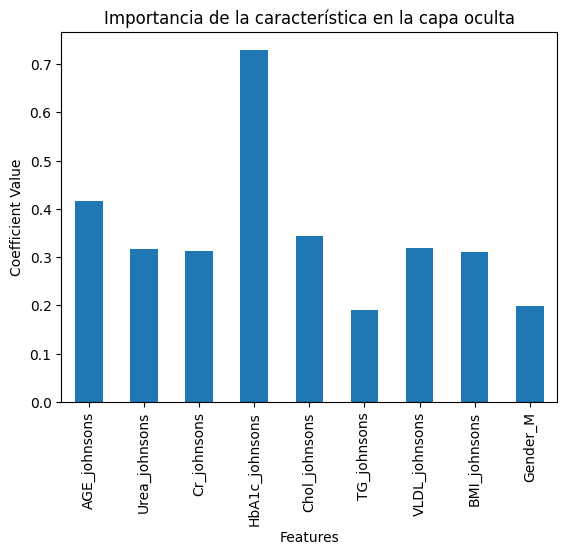

In [144]:
weights_matrix = model.get_layer('oculta_1').get_weights()[0]
weights = np.mean(np.abs(weights_matrix), axis=1)


coeffs = pd.DataFrame(data=weights, index=X_train.columns, columns=["Coefficient"])
coeffs.plot(kind='bar', legend=None)
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.title("Importancia de la característica en la capa oculta")
plt.show()